In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import os
import shapely
from shapely import LineString, MultiPoint, Polygon
import math
import skimage as ski
from skimage.transform import rotate
from astropy.convolution import Gaussian2DKernel, convolve,interpolate_replace_nans
from skimage.restoration import inpaint

In [2]:
dirpath = os.getcwd()
kp_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_labels\labels\keypoints")
sg_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_labels\labels\segments")
im_dir = os.path.join(os.path.normpath(dirpath + os.sep + os.pardir), r"udder_labels\frames_tolabel_depth")
out_dir = r"results_line_labeled"
cow_list = os.listdir(im_dir)

In [ ]:
def mk_dir(dirpath):
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)
        
def get_angle(right_kp, left_kp):
    angle = np.arctan2(right_kp[1]-left_kp[1], right_kp[0]-left_kp[0])
    return angle

def get_center(right_kp, left_kp):
    return shapely.centroid(MultiPoint([right_kp, left_kp])).coords[0] 

def get_orientation(right_kp, left_kp):
    if right_kp[0] < left_kp[0]:
        orientation = -1 # up 
    else: 
        orientation = 1 # down
    return orientation

def rotate_udder(udder, right_kp, left_kp):
    k = get_orientation(right_kp, left_kp)
    center = get_center(right_kp, left_kp)
    angle = get_angle(right_kp, left_kp)
    rotated_udder = rotate(udder, np.rad2deg(k*angle), center = center, preserve_range = True)
    return rotated_udder

def rotate_points(right_kp, left_kp):
    k = get_orientation(right_kp, left_kp)
    points = np.concatenate([[right_kp], [left_kp]])
    points2 = points.copy()
    angle = get_angle(right_kp, left_kp)
    center = get_center(right_kp, left_kp)
    rot_mat = np.array([[np.cos(-k*angle), -np.sin(-k*angle)], [np.sin(-k*angle), np.cos(-k*angle)]])
    #
    points2[:, 0] = points[:, 0] - center[0]
    points2[:, 1] = points[:, 1] - center[1]
    # 
    points2 = np.transpose(np.dot(rot_mat, np.transpose(points2[:, :2])))
    points2[:, 0] = points2[:, 0] + center[0]
    points2[:, 1] = points2[:, 1] + center[1]
    rotated_points = points2.copy()
    return rotated_points

def udder_line_conv(img,udder_shp, rf_kp, lf_kp, ax):
    img[img ==0] = np.nan
    kernel = Gaussian2DKernel(x_stddev=1)
    udder_conv = convolve(img, kernel)
    udder2 = rotate_udder(udder_conv, rf_kp, lf_kp)
    points2 = rotate_points(rf_kp, lf_kp)
    yloc = np.floor(points2[0,1]).astype(int)
    # fig, ax = plt.subplots()
    for i in range(-10,10):
        yloc2 = yloc + i 
        line = LineString([(0, yloc2), (im_width, yloc2)])
        intersection = udder_shp.exterior.intersection(line).geoms
        endpoints = np.array([list(intersection[0].coords[0]), list(intersection[1].coords[0])])
        start = np.floor(endpoints[np.argmin(endpoints[:, 0])]).astype(int)
        end = np.floor(endpoints[np.argmax(endpoints[:, 0])]).astype(int)
        line_vals = udder2[yloc2][list(range(start[0], end[0]))]
        ax.plot(line_vals)

def udder_line_inp(img,udder_shp, rf_kp, lf_kp, ax):
    miss_mask = img.copy()
    miss_mask[: :] = 0
    miss_mask[udder == 0] = 1
    inp_udder = inpaint.inpaint_biharmonic(img, miss_mask)
    udder2 = rotate_udder(inp_udder, rf_kp, lf_kp)
    points2 = rotate_points(rf_kp, lf_kp)
    yloc = np.floor(points2[0,1]).astype(int)
    # fig, ax = plt.subplots()
    for i in range(-10,10):
        yloc2 = yloc + i 
        line = LineString([(0, yloc2), (im_width, yloc2)])
        intersection = udder_shp.exterior.intersection(line).geoms
        endpoints = np.array([list(intersection[0].coords[0]), list(intersection[1].coords[0])])
        start = np.floor(endpoints[np.argmin(endpoints[:, 0])]).astype(int)
        end = np.floor(endpoints[np.argmax(endpoints[:, 0])]).astype(int)
        line_vals = udder2[yloc2][list(range(start[0], end[0]))]
        ax.plot(line_vals)

KeyboardInterrupt: 

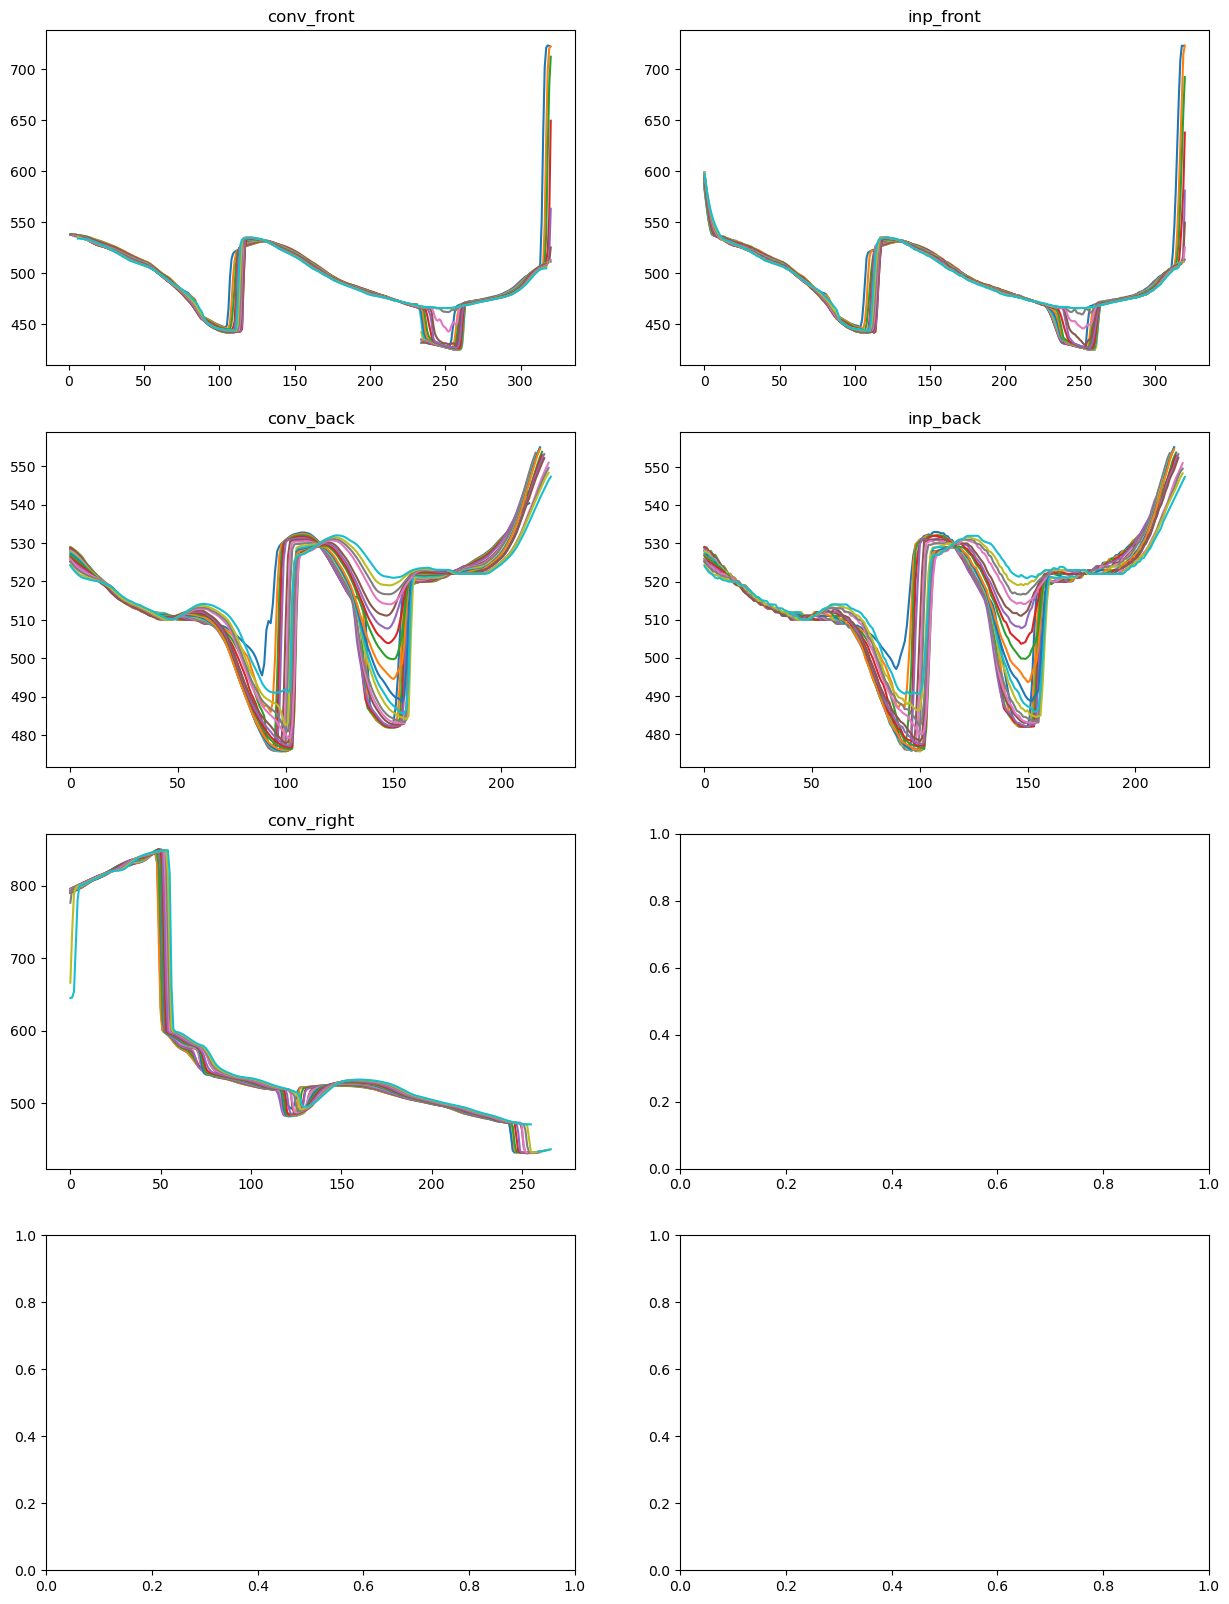

In [4]:
for cow in cow_list:
    filenames = os.listdir(os.path.join(im_dir, cow))
    out_path = os.path.join(out_dir, cow)
    mk_dir(out_path)
    for file in filenames[:1]:
        
        label = file.replace(".tif", ".txt")
        udder = ski.io.imread(os.path.join(im_dir, cow, file))
        img = udder.copy().astype("float")
        
        # image shape is in y,x oder
        im_size = udder.shape
        im_height = im_size[0]
        im_width = im_size[1]
        
        # segments are in x,y oder 
        with open(os.path.join(sg_dir, label), "r") as f:
            mask = np.array([float(point) for point in f.read().split(" ")][1:])
        mask = mask.reshape((int(len(mask)//2),2))
        
        # keypoints are in x,y oder
        with open(os.path.join(kp_dir, label), "r") as f:
            data =  [float(point) for point in f.read().split(" ")]
            box = np.array(data[1:5])
            points = np.array(data[5:])
        points = points.reshape((4,3))
        box = box.reshape((2,2))
        box[:, 0] = box[:, 0] * im_width
        box[:, 1] = box[:, 1] * im_height
        box[0, 0] = box[0, 0] - box[1, 0]/2
        box[0, 1] = box[0, 1] - box[1, 1]/2

        points[:, 0] = points[:, 0] * im_width
        points[:, 1] = points[:, 1] * im_height
        
        lf_kp = points[0, :2]
        rf_kp = points[1, :2]
        lb_kp = points[2, :2]
        rb_kp = points[3, :2]

        # polygon requires y,x order
        polygon2 = [[coord[0]*im_width, coord[1] * im_height] for coord in mask]
        udder_shp = shapely.Polygon(polygon2)
        
        fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8))= plt.subplots(4, 2,  figsize=(15, 20))
        udder_line_conv(img, udder_shp, rf_kp, lf_kp, ax1)
        ax1.title.set_text('conv_front')
        udder_line_inp(img,udder_shp, rf_kp, lf_kp, ax2)
        ax2.title.set_text('inp_front') 
        udder_line_conv(img,udder_shp, rb_kp, lb_kp, ax3)
        ax3.title.set_text('conv_back')
        udder_line_inp(img, udder_shp, rb_kp, lb_kp, ax4)
        ax4.title.set_text('inp_back')
        udder_line_conv(img,udder_shp, rf_kp, rb_kp, ax5)
        ax5.title.set_text('conv_right')
        udder_line_inp(img,udder_shp, rf_kp, rb_kp, ax6)
        ax6.title.set_text('inp_right')
        udder_line_conv(img, udder_shp, lf_kp, lb_kp, ax7)
        ax7.title.set_text('conv_left')
        udder_line_inp(img, udder_shp, lf_kp, lb_kp, ax8)
        ax8.title.set_text('conv_left')
        
        fig.suptitle(f"cowID: {cow}")
        fig.savefig(os.path.join(out_path, file.replace("tif", "png")))
        plt.close(fig)   

In [ ]:
udder_line(img, udder_shp, rf_kp, lf_kp, ax)

In [ ]:
# https://scikit-image.org/docs/stable/auto_examples/filters/plot_inpaint.html
# https://docs.astropy.org/en/stable/convolution/#convolution-and-filtering-astropy-convolution